In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load pv data for continuous_1
path = '../dataset/pv/20230309/continuous_1.gz'
data = pd.read_csv(path, compression='gzip', skiprows=7, delimiter='\t',header=None)
start_s=0
end_s=50
ms=False
# data = data[:][:-7] #remove the final 7 rows for continuous_2 dataset
for j in range(len(data.columns)):
    data[j] = [float(i) for i in data[j]]
    
if not ms:  
    ts = data[0][1]-data[0][0]
    fs = int(np.rint(1/ts))
else:
    ts = (data[0][1]-data[0][0])/1000
    fs = int(np.rint(1/ts))

time = data[0][int(start_s*fs): int(end_s*fs)].to_numpy()-data[0][0]-start_s
pv = data[data.columns[1:]][int(start_s*fs): int(end_s*fs)].to_numpy()
audio = np.zeros(end_s*fs - start_s*fs)

[]
0
1
2
3
[[ 1.87121111e+02+0.00000000e+00j  3.67135474e+02+0.00000000e+00j
   3.67234747e+02+0.00000000e+00j ...  3.68742760e+02+0.00000000e+00j
   3.68743737e+02+0.00000000e+00j  1.80687340e+02+0.00000000e+00j]
 [-9.53692412e+01+1.16762725e+02j -1.83580821e+02+4.42387237e-02j
  -1.83621191e+02+5.33539791e-03j ... -1.84372062e+02-5.83015913e-04j
  -1.84369885e+02+6.95540916e-03j -8.84979927e+01-1.17339676e+02j]
 [ 3.63848926e+00-7.77612013e+01j  9.80366496e-03-2.69409610e-03j
   5.43584574e-03+2.13198362e-03j ...  3.93050636e-04-9.43608062e-04j
  -2.54850844e-03-5.36897223e-03j -3.69145630e+00+7.81732884e+01j]
 ...
 [ 3.67071419e+00-2.29598872e-01j  5.68006863e-03+3.90606878e-03j
  -1.55178547e-03+7.61347577e-03j ...  8.57574879e-04-8.07004532e-04j
   4.92435717e-05-2.38129848e-03j -3.68574725e+00+2.29397060e-01j]
 [-3.67021657e+00+1.16943717e-01j -2.32619343e-03-3.73895725e-03j
  -1.30825951e-03-9.42691888e-03j ... -1.23679468e-03+3.66264832e-03j
   1.62600118e-03-6.18238745e-04j  3

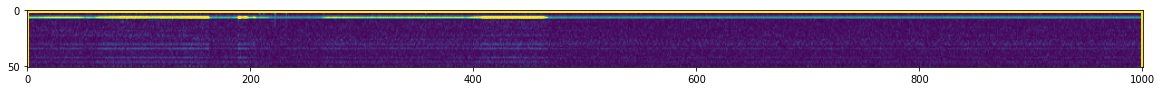

In [17]:
from scipy import signal

continuous_1=[]
print(continuous_1)
for ii in range(pv.shape[1]):
    print(ii)
# perform fft on pv data with window length of 0.1s
    f, t, Zxx = signal.stft(pv[:,ii], fs, nperseg=100, axis=-1)
    continuous_1.append(Zxx)

# print(np.shape(Zxx))
print(continuous_1[1])
fig = plt.figure(figsize=[20, 10])
plt.imshow(np.abs(continuous_1[3]),vmax=0.1,vmin=0)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [35]:
class LSTMTagger(nn.Module):

    def __init__(self, input_dim, hidden_dim, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, data):
        lstm_out, _ = self.lstm(data.view(-1, 1, len(data)))
        print(lstm_out.shape)
        print(len(lstm_out))
        tag_space = self.hidden2tag(lstm_out.view(len(lstm_out),-1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
INPUT_DIM = 4
HIDDEN_DIM = 6
TARGET_SIZE = 4

In [37]:
model = LSTMTagger(INPUT_DIM, HIDDEN_DIM, TARGET_SIZE)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
print(len(continuous_1))
with torch.no_grad():
    inputs = torch.FloatTensor(continuous_1)
    tag_scores = model(inputs)
    print(tag_scores.size())
    print(tag_scores)

4


/var/folders/8z/m4kbswp17qq4hy08by5m6m800000gn/T/ipykernel_88589/3971426748.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  inputs = torch.FloatTensor(continuous_1)


torch.Size([51051, 1, 6])
51051
torch.Size([51051, 4])
tensor([[-1.2471, -1.4623, -1.2110, -1.6980],
        [-1.0252, -1.5303, -1.1708, -2.1655],
        [-1.0181, -1.5353, -1.1681, -2.1859],
        ...,
        [-1.2410, -1.5449, -1.3617, -1.4216],
        [-1.2411, -1.5449, -1.3615, -1.4216],
        [-1.1768, -1.5911, -1.3111, -1.5210]])
